In [1]:
import pandas
import numpy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tqdm import tqdm

## 1.1 Loading dataset 

### Ratings data

In [2]:
ratings = pandas.read_csv("./ml-latest/ratings.csv")
ratings = ratings.drop(columns="timestamp")
ratings

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5
...,...,...,...
27753439,283228,8542,4.5
27753440,283228,8712,4.5
27753441,283228,34405,4.5
27753442,283228,44761,4.5


In [3]:
# explore the data
def explore_ratings():
    print("User count:", len(ratings["userId"].unique())) 
    print("Min user ID:", ratings["userId"].min())
    print("Max user ID:", ratings["userId"].max())
    print()

    print("Movie count:", len(ratings["movieId"].unique())) 
    print("Min Movie ID:", ratings["movieId"].min())
    print("Max Movie ID:", ratings["movieId"].max())
    print()

    print("Max rating:", ratings["rating"].max())
    print("Min rating:", ratings["rating"].min())
    print("Mean rating:", ratings["rating"].mean())
    print("Std rating:", ratings["rating"].std())
    
explore_ratings()

User count: 283228
Min user ID: 1
Max user ID: 283228

Movie count: 53889
Min Movie ID: 1
Max Movie ID: 193886

Max rating: 5.0
Min rating: 0.5
Mean rating: 3.5304452124932677
Std rating: 1.066352750231988


In [4]:
# downsampling users (only keep 1%)
ratings = ratings[ratings["userId"]%100==0].copy().reset_index(drop=True)

In [5]:
# explore the data
explore_ratings()

User count: 2832
Min user ID: 100
Max user ID: 283200

Movie count: 28683
Min Movie ID: 1
Max Movie ID: 193297

Max rating: 5.0
Min rating: 0.5
Mean rating: 3.517344979247971
Std rating: 1.0594239782374006


### Movies data

In [6]:
movies = pandas.read_csv("./ml-latest/movies.csv")
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed)
58094,193878,Les tribulations d'une caissière (2011),Comedy
58095,193880,Her Name Was Mumu (2016),Drama
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi


### Reset userId and movieId

In [7]:
# reset index
user_ID_to_user_index = dict(map(reversed, enumerate(ratings["userId"].unique())))
movie_ID_to_movie_index = dict(map(reversed, enumerate(ratings["movieId"].unique())))

ratings["userId"] = ratings["userId"].apply(user_ID_to_user_index.get)
ratings["movieId"] = ratings["movieId"].apply(movie_ID_to_movie_index.get)

movies["movieId"] = movies["movieId"].apply(lambda x:movie_ID_to_movie_index.get(x, -1))
movies = movies[movies["movieId"] != -1]

### Flatten movies

In [8]:
movies_flattened = movies.copy()
movies_flattened["genres"] = movies_flattened["genres"].apply(lambda x:x.split("|"))
movies_flattened = movies_flattened.explode("genres")
movies_flattened

,movieId,title,genres
0,0,Toy Story (1995),Adventure
0,0,Toy Story (1995),Animation
0,0,Toy Story (1995),Children
0,0,Toy Story (1995),Comedy
0,0,Toy Story (1995),Fantasy
...,...,...,...
57823,26645,Next Gen (2018),Adventure
57823,26645,Next Gen (2018),Animation
57849,26651,Scooby-Doo! and the Gourmet Ghost (2018),Adventure
57849,26651,Scooby-Doo! and the Gourmet Ghost (2018),Animation


### Split train-test dataset

In [9]:
ratings_train, ratings_test = train_test_split(ratings.to_numpy(dtype=object), test_size=0.2)

## 1.2 Building user and movie embeddings 

In [10]:
from ProbabilisticMatrixFactorization import PMF
# reference: https://github.com/fuhailin/Probabilistic-Matrix-Factorization

pmf = PMF()

pmf.set_params({"num_feat": 30, "epsilon": 1, 
                "_lambda": 0.1, "momentum": 0.8, 
                "maxepoch": 20, "num_batches": len(ratings_train)//1000,
                "batch_size": 1000})

pmf.fit(ratings_train.astype(float), ratings_test.astype(float))

Training RMSE: 1.057298, Test RMSE 1.057326
Training RMSE: 1.052765, Test RMSE 1.056517
Training RMSE: 1.045640, Test RMSE 1.053689
Training RMSE: 1.030051, Test RMSE 1.044793
Training RMSE: 0.999257, Test RMSE 1.025587
Training RMSE: 0.958682, Test RMSE 1.001421
Training RMSE: 0.920345, Test RMSE 0.979150
Training RMSE: 0.888918, Test RMSE 0.960885
Training RMSE: 0.863346, Test RMSE 0.946908
Training RMSE: 0.842030, Test RMSE 0.936481
Training RMSE: 0.823014, Test RMSE 0.928209
Training RMSE: 0.805862, Test RMSE 0.921692
Training RMSE: 0.789901, Test RMSE 0.916437
Training RMSE: 0.774354, Test RMSE 0.912052
Training RMSE: 0.760052, Test RMSE 0.908424
Training RMSE: 0.746100, Test RMSE 0.905620
Training RMSE: 0.732737, Test RMSE 0.903147
Training RMSE: 0.720189, Test RMSE 0.901537
Training RMSE: 0.707766, Test RMSE 0.900000
Training RMSE: 0.695825, Test RMSE 0.898548


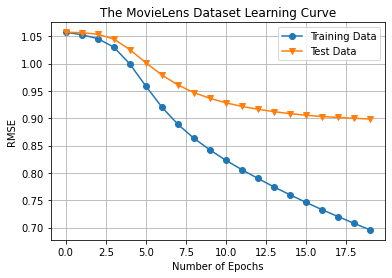

In [11]:
# Check performance by plotting train and test errors
import matplotlib.pyplot as plt

plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
plt.title('The MovieLens Dataset Learning Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

In [12]:
ratings_mean = pmf.mean_inv
print(ratings_mean)

user_embeddings = pmf.w_User
print(user_embeddings.shape)

movie_embeddings = pmf.w_Item
print(movie_embeddings.shape)

3.5155468276126114
(2832, 30)
(28683, 30)


## 1.3 Building Recommender Model (given user, recommend movie) (XiaoChen)

In [13]:
prediction = numpy.dot(pmf.w_User, pmf.w_Item.transpose()) + pmf.mean_inv
pandas.DataFrame(prediction)

,0,1,2,3,4,5,6,7,8,9,...,28673,28674,28675,28676,28677,28678,28679,28680,28681,28682
0,4.033416,3.784438,4.054193,3.964909,3.215581,4.196204,4.105716,3.875357,3.548573,4.167683,...,3.579230,3.552577,3.636475,3.403843,3.519186,3.479286,3.466655,3.702966,3.665636,3.586841
1,3.616564,3.686218,3.697873,3.786009,3.770970,3.782229,3.739677,3.571163,3.485479,3.748766,...,3.525932,3.517079,3.582908,3.486628,3.567605,3.530631,3.560298,3.555576,3.511358,3.501451
2,3.979189,3.101655,4.204232,3.986692,2.839043,4.171580,3.946160,3.724177,3.266751,4.409706,...,3.509625,3.368900,3.480413,3.388947,3.383440,3.431529,3.436872,3.662937,3.472416,3.599309
3,3.649304,3.270045,3.576117,3.610865,3.227405,3.622378,3.601374,3.675873,3.373741,3.729478,...,3.402723,3.464154,3.640426,3.420466,3.484768,3.508910,3.404646,3.571634,3.487906,3.579217
4,2.598067,1.897867,2.921524,2.880548,1.857079,2.718679,3.083350,2.555685,2.960319,2.660686,...,3.462214,3.441633,3.375815,3.627426,3.359895,3.693441,3.685100,3.294228,3.471798,3.668474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827,3.880534,3.932701,3.755344,3.861457,3.868065,3.869686,3.571841,3.823625,3.735866,3.873360,...,3.517701,3.590691,3.604054,3.573127,3.481300,3.459891,3.512809,3.624508,3.492498,3.493246
2828,4.134282,3.258525,3.983442,4.015341,1.762885,3.979755,4.175842,3.286324,2.903411,4.059865,...,3.290958,3.398506,3.583893,3.587566,3.408499,3.542030,3.513985,3.701132,3.683175,3.805607
2829,3.921465,3.042882,3.744142,3.710927,2.474511,3.880566,3.822670,3.661386,3.278851,3.947937,...,3.571063,3.499098,3.600926,3.477981,3.434358,3.427671,3.467357,3.650425,3.527536,3.669571
2830,4.076404,2.917351,3.963344,3.710734,2.454884,4.034126,3.850690,3.904815,3.214368,4.019437,...,3.519663,3.486343,3.680920,3.470985,3.520137,3.446194,3.436426,3.607987,3.575171,3.669739


In [14]:
# set the prediction value for the movies that user already rated/watched to 0
# prevent the recommendation system recommending already watched movies to the user

for each in ratings.to_numpy(dtype=object):
    prediction[each[0],each[1]] = 0
    
pandas.DataFrame(prediction)

,0,1,2,3,4,5,6,7,8,9,...,28673,28674,28675,28676,28677,28678,28679,28680,28681,28682
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.579230,3.552577,3.636475,3.403843,3.519186,3.479286,3.466655,3.702966,3.665636,3.586841
1,3.616564,3.686218,3.697873,3.786009,3.770970,3.782229,3.739677,3.571163,3.485479,3.748766,...,3.525932,3.517079,3.582908,3.486628,3.567605,3.530631,3.560298,3.555576,3.511358,3.501451
2,3.979189,3.101655,0.000000,0.000000,2.839043,4.171580,3.946160,3.724177,3.266751,4.409706,...,3.509625,3.368900,3.480413,3.388947,3.383440,3.431529,3.436872,3.662937,3.472416,3.599309
3,0.000000,3.270045,3.576117,3.610865,3.227405,3.622378,0.000000,3.675873,3.373741,3.729478,...,3.402723,3.464154,3.640426,3.420466,3.484768,3.508910,3.404646,3.571634,3.487906,3.579217
4,2.598067,1.897867,0.000000,2.880548,1.857079,2.718679,3.083350,2.555685,2.960319,2.660686,...,3.462214,3.441633,3.375815,3.627426,3.359895,3.693441,3.685100,3.294228,3.471798,3.668474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827,3.880534,3.932701,3.755344,3.861457,0.000000,3.869686,3.571841,3.823625,3.735866,3.873360,...,3.517701,3.590691,3.604054,3.573127,3.481300,3.459891,3.512809,3.624508,3.492498,3.493246
2828,4.134282,3.258525,3.983442,4.015341,1.762885,3.979755,4.175842,3.286324,2.903411,4.059865,...,3.290958,3.398506,3.583893,3.587566,3.408499,3.542030,3.513985,3.701132,3.683175,3.805607
2829,0.000000,3.042882,3.744142,3.710927,2.474511,0.000000,3.822670,0.000000,0.000000,3.947937,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2830,0.000000,2.917351,3.963344,3.710734,2.454884,0.000000,3.850690,3.904815,3.214368,4.019437,...,3.519663,3.486343,3.680920,3.470985,3.520137,3.446194,3.436426,3.607987,3.575171,3.669739


In [15]:
# Recommend TOP 20 movies for each user based on predicted rating

# return the index data along each row in sorted order
ordered_index = numpy.argsort(prediction, axis=1)
recommendation_index = ordered_index[:,-20:][:,::-1]
recommendation_index = pandas.DataFrame(recommendation_index)
recommendation_index

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1947,2713,1794,601,3380,3020,804,1049,1653,895,2784,891,511,2995,1538,795,1896,1337,884,706
1,4298,101,539,1790,1160,223,891,98,127,1580,1419,256,938,276,1330,1874,2433,356,191,215
2,41,932,641,127,3971,2089,87,1930,81,1907,934,849,706,632,1848,1299,138,845,3748,107
3,99,1794,406,4783,147,98,601,933,939,938,3971,4784,45,1336,606,4247,159,1947,541,3965
4,5286,5293,5107,4931,3013,6826,10703,5231,5294,23731,5285,1468,3733,12254,1564,18607,6376,8960,7861,26863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827,2094,3199,2456,3666,1816,1810,25,2388,309,670,2313,190,2082,33,1778,2280,1853,2281,2303,2440
2828,1299,45,79,87,41,932,102,1781,11,3971,252,150,896,795,223,3350,5041,1947,891,900
2829,2781,600,5010,5041,4247,579,4583,891,3791,3748,993,2835,2089,1983,2995,2713,2749,2791,129,1055
2830,4783,98,579,938,1049,4247,932,600,511,11,933,1947,891,706,130,934,3971,880,1336,2031


In [16]:
movieId_to_title_dict = dict(movies.to_numpy()[:,0:2])
recommendation_titles = recommendation_index.applymap(movieId_to_title_dict.get)
pandas.DataFrame(recommendation_titles).head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Fog of War: Eleven Lessons from the Life of Ro...,Seven Samurai (Shichinin no samurai) (1954),Lawrence of Arabia (1962),"Seventh Seal, The (Sjunde inseglet, Det) (1957)","Secret Life of Walter Mitty, The (2013)",Up (2009),Harvey (1950),Yojimbo (1961),Vertigo (1958),Ran (1985),Some Folks Call It a Sling Blade (1993),Schindler's List (1993),"Professional, The (Le professionnel) (1981)",Elizabeth (1998),WALL·E (2008),Waiting for Guffman (1996),Psycho (1960),Hoop Dreams (1994),Central Station (Central do Brasil) (1998)
1,Stalag 17 (1953),2001: A Space Odyssey (1968),Full Metal Jacket (1987),Pink Floyd: The Wall (1982),"Prestige, The (2006)",American History X (1998),Some Folks Call It a Sling Blade (1993),"Godfather, The (1972)","Godfather: Part II, The (1974)","Lock, Stock & Two Smoking Barrels (1998)",Great Expectations (1998),Deliverance (1972),"Treasure of the Sierra Madre, The (1948)","Green Mile, The (1999)","Doors, The (1991)",The Revenant (2015),Monty Python's And Now for Something Completel...,M*A*S*H (a.k.a. MASH) (1970),Pi (1998),"Untouchables, The (1987)"
2,Pulp Fiction (1994),One Flew Over the Cuckoo's Nest (1975),"Dark Knight, The (2008)","Godfather: Part II, The (1974)",Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),City of God (Cidade de Deus) (2002),Wallace & Gromit: The Best of Aardman Animatio...,Inglourious Basterds (2009),Fargo (1996),"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...","Third Man, The (1949)",Whiplash (2014),Central Station (Central do Brasil) (1998),"Departed, The (2006)",Interstellar (2014),Wallace & Gromit: A Close Shave (1995),Chinatown (1974),"Grand Budapest Hotel, The (2014)",Papillon (1973),Reservoir Dogs (1992)
3,Casablanca (1942),Seven Samurai (Shichinin no samurai) (1954),"Lord of the Rings: The Return of the King, The...",All About Eve (1950),Cool Hand Luke (1967),"Godfather, The (1972)",Lawrence of Arabia (1962),12 Angry Men (1957),Duck Soup (1933),"Treasure of the Sierra Madre, The (1948)",Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Rebecca (1940),"Shawshank Redemption, The (1994)",To Kill a Mockingbird (1962),"Fistful of Dollars, A (Per un pugno di dollari...",Once Upon a Time in the West (C'era una volta ...,Jaws (1975),Cinema Paradiso (Nuovo cinema Paradiso) (1989),Evil Dead II (Dead by Dawn) (1987),"Night at the Opera, A (1935)"


# Task 2. Building Graph

In [17]:
import networkx as nx

In [18]:
# this function add "user_" prefix to a userID
# numpy.frompyfunc is a wrapper, will make a function works on all elements in an numpy array
user_id_stringify = numpy.frompyfunc(lambda x:"user_"+str(int(x)), 1, 1)
# this function add "movie_" prefix to a movieID
movie_id_stringify = numpy.frompyfunc(lambda x:"movie_"+str(int(x)), 1, 1) 
# add "genre_" prefix to genres
add_genre_prefix = numpy.frompyfunc(lambda x:"genre_"+x, 1, 1) 

def build_graph(ratings, movies):
    ratings = ratings.copy()
    movies = movies.copy()
    
    # remove movies that no one rated
    rated_movie_ids = set(ratings[:,1])
    is_rated_movies = list(map(lambda movie: movie[0] in rated_movie_ids, movies.tolist()))
    movies = movies[is_rated_movies]
    
    # add prefixes to userIDs and movidIDs
    ratings[:, 0] = user_id_stringify(ratings[:, 0])
    ratings[:, 1] = movie_id_stringify(ratings[:, 1])
    movies[:, 0] = movie_id_stringify(movies[:, 0])
    movies[:, 2] = add_genre_prefix(movies[:, 2])

    # gether all the nodes, nodes include users, movies, and genres
    # nodes are unique
    user_ids = numpy.unique(ratings[:, 0])
    movies_ids = numpy.unique(movies[:, 0])
    genres = numpy.unique(movies[:, 2])
    
    # edges
    # if user has a rating for a movie then there is an edge
    user_movie_edges = ratings[:, [0,1]]
    # if movie has a genre, there is an edge
    movie_genre_edges = movies[:, [0,2]]

    # creating graph
    graph = nx.Graph()

    # adding nodes
    graph.add_nodes_from(user_ids, color="royalblue")
    graph.add_nodes_from(movies_ids, color = "orange")
    graph.add_nodes_from(genres, color = "springgreen")
    
    # adding edges
    graph.add_edges_from(user_movie_edges)
    graph.add_edges_from(movie_genre_edges)
    
    return graph


train_dataset_graph = build_graph(ratings_train, movies_flattened.to_numpy(dtype=object))
test_dataset_graph = build_graph(ratings_test, movies_flattened.to_numpy(dtype=object))

### Graph visualization 

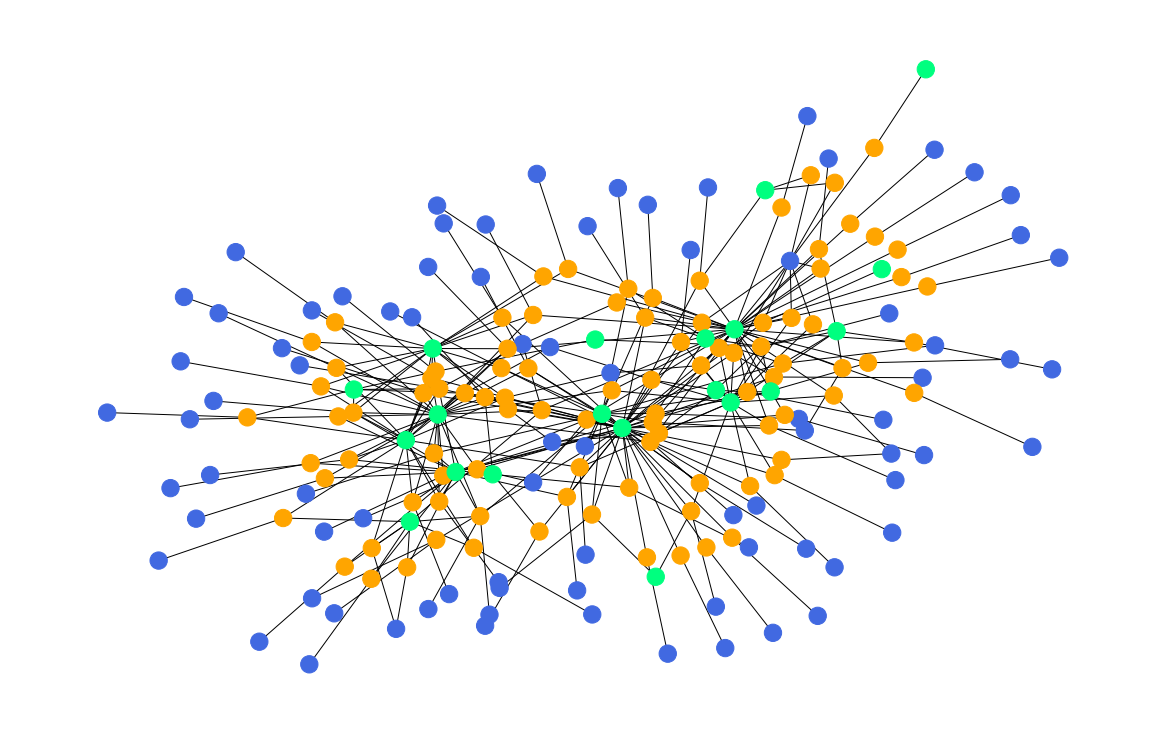

In [19]:
plt.figure(figsize=(16,10))
sample_graph = build_graph(ratings_test[:100], movies_flattened.to_numpy(dtype=object))

labels = nx.get_node_attributes(sample_graph, 'color')
nx.draw(sample_graph, node_color = labels.values())

## 2.1 movie with the highest degree of centraility 

In [20]:
def movie_with_highest_degree_of_centrality(graph):
    degrees = nx.degree_centrality(graph)
    # filter movie nodes
    degrees = list(filter(lambda x:x[0].startswith("movie_"), degrees.items()))
    # sort degrees
    degrees = sorted(degrees, key=lambda x:x[1], reverse=True)
    
    # get movie name
    movie_id = int(degrees[0][0].split("_")[1])
    movie_name = movies[movies["movieId"] == movie_id]
    
    #return movieId with highest degree 
    return degrees[0], movie_name

In [21]:
movie_with_highest_degree_of_centrality(train_dataset_graph)

(('movie_45', 0.02898084619782733),
      movieId                             title       genres
 315       45  Shawshank Redemption, The (1994)  Crime|Drama)

In [22]:
movie_with_highest_degree_of_centrality(test_dataset_graph)

(('movie_45', 0.015328994938539408),
      movieId                             title       genres
 315       45  Shawshank Redemption, The (1994)  Crime|Drama)

## 2.2 gener with the highest degree of centraility 

In [23]:
def gener_with_highest_degree_of_centrality(graph):
    degrees = nx.degree_centrality(graph)
    # filter genre nodes
    degrees = list(filter(lambda x:x[0].startswith("genre_"), degrees.items()))
    # sort degrees
    degrees = sorted(degrees, key=lambda x:x[1], reverse=True)
    #return genre with highest degree 
    return degrees[0]

In [24]:
gener_with_highest_degree_of_centrality(train_dataset_graph)

('genre_Drama', 0.44357489994282445)

In [25]:
gener_with_highest_degree_of_centrality(test_dataset_graph)

('genre_Drama', 0.3893709327548807)

## 2.3 use your recommender system to predict the ratings for the test dataset. Build a graph for the predictions and answer question 2.2 and 2.1 for this dataset as well 

### Predict ratings for the test dataset

In [26]:
# this function takes a userId and movieId as input
# then calculate the predicted rating 
def predict_rating(user_id, movid_id):
    user_embedding = user_embeddings[user_id]
    movie_embedding = movie_embeddings[movie_id]
    rating = (user_embedding * movie_embedding).sum() + ratings_mean
    return rating

predictions = []
for row in ratings_test:
    user_id = row[0]
    movie_id = row[1]
    pred_rating = predict_rating(user_id, movie_id)
    predictions.append([user_id, movie_id, pred_rating])
    
predictions = numpy.array(predictions).astype(object)
predictions

array([[1230.0, 25216.0, 3.565912944301125],
       [1429.0, 918.0, 4.103748683090851],
       [639.0, 141.0, 4.430142132804649],
       ...,
       [869.0, 5077.0, 3.3439432288540463],
       [669.0, 132.0, 3.8655800216868337],
       [1230.0, 25943.0, 3.5681601140112695]], dtype=object)

### build a graph for predictions

In [27]:
prediction_graph = build_graph(predictions, movies_flattened.to_numpy(dtype=object))

### Question 2.1

In [28]:
movie_with_highest_degree_of_centrality(prediction_graph)

(('movie_45', 0.015328994938539408),
      movieId                             title       genres
 315       45  Shawshank Redemption, The (1994)  Crime|Drama)

### Question 2.2

In [29]:
gener_with_highest_degree_of_centrality(prediction_graph)

('genre_Drama', 0.3893709327548807)

### Graph visualization 

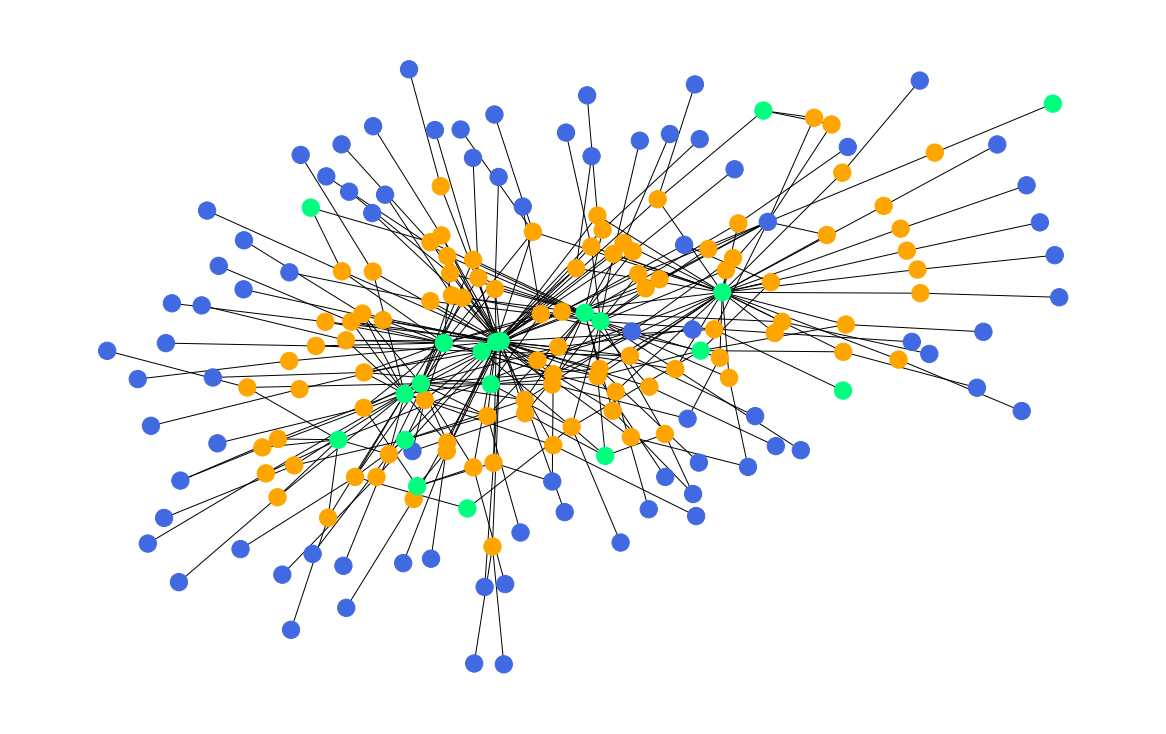

In [30]:
plt.figure(figsize=(16,10))
sample_graph = build_graph(predictions[:100], movies_flattened.to_numpy(dtype=object))

labels = nx.get_node_attributes(sample_graph, 'color')
nx.draw(sample_graph, node_color = labels.values())